<a href="https://colab.research.google.com/github/JossCastelazo/MiniProject2/blob/main/Mini_Project_2_slime_mold_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Slime Mold Spatio-Temporal — Week 1 Starter

In [1]:
#@title Setup (optional installs)
!pip -q install zarr tifffile h5py scikit-image tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 97.1 MB/s eta 0:00:00


In [2]:
#@title Imports & seed
import os, random, numpy as np, matplotlib.pyplot as plt, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import pandas as pd
import zarr                              # format for the movies
from tqdm.notebook import tqdm          # clean progress bars in Colab

from skimage import filters, measure, morphology, exposure  # basic image ops
from scipy.ndimage import center_of_mass, gaussian_filter   # for labels & denoising


try:
    import tifffile as tiff
except Exception:
    tiff = None
try:
    import h5py
except Exception:
    h5py = None

def set_seed(seed=7):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(7); DEVICE


'cuda'

## 1) Load data (choose a reader and set `DATA_PATH`)

In [3]:
#@title Readers
from google.colab import drive
drive.mount("/content/drive")

DATA_ROOT = Path("/content/drive/MyDrive/DictyProject/Dicty-Data/Data")

DATA_PATH = "/content/drive/MyDrive/DictyProject/Dicty-Data/Data/mixin_test64" # e.g., "/content/drive/MyDrive/Dicty-Data/Data/mixin_test44/2024-01-17_ERH_23hr_ERH Red FarRed.zarr"

def read_npy(path): return np.load(path)
def read_h5(path, key="images"):
    assert h5py is not None, "install h5py"
    import h5py as _h5
    with _h5.File(path, "r") as f: arr = f[key][:]
    return np.array(arr)
def read_tiff_stack(path):
    assert tiff is not None, "install tifffile"
    return np.asarray(tiff.imread(path))

def read_zarr(path):
    """Read a Zarr time-lapse stack (T, H, W) or (T, C, H, W)."""
    arr = zarr.open(path, mode="r")
    data = np.asarray(arr)
    return data.astype(np.float32)

# raw = read_npy(DATA_PATH)
# raw = read_h5(DATA_PATH, key="images")
# raw = read_tiff_stack(DATA_PATH)


# synthetic placeholder
def synthetic_demo(T=60, H=64, W=64):
    x = np.zeros((T, H, W), np.float32)
    for t in range(T):
        cx = int(H/2 + (10 + 5*np.sin(t/8)) * np.cos(t/10))
        cy = int(W/2 + (10 + 5*np.sin(t/8)) * np.sin(t/10))
        x[t, cx % H, cy % W] = 1.0
        x[t] = np.clip(
            x[t] + 0.1*np.random.randn(H, W).astype(np.float32),
            0, 1
        )
    return x

# raw = synthetic_demo()
USE_SYNTHETIC = False
if USE_SYNTHETIC:
    raw = synthetic_demo()
    ZARR_PATH = None
else:
  EXPERIMENT = "mixin_test64"

  exp_root = DATA_ROOT / EXPERIMENT
  zarr_files = sorted(exp_root.glob("*.zarr"))
  assert len(zarr_files) > 0, f"No .zarr files found in {exp_root}"

  ZARR_PATH = zarr_files[0]
  print("Loading Zarr file:", ZARR_PATH)
  raw = read_zarr(ZARR_PATH)

raw.shape

Mounted at /content/drive
Loading Zarr file: /content/drive/MyDrive/DictyProject/Dicty-Data/Data/mixin_test64/ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr


(200, 1, 48, 256, 256)

shape: (200, 1, 48, 256, 256) min/max: 0.0 13210.0


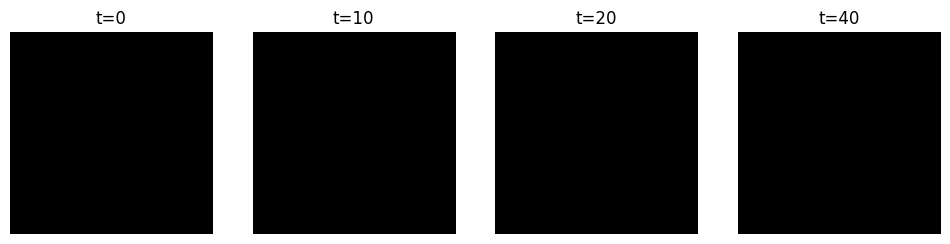

In [4]:
#@title Inspect & visualize a few frames (with contrast normalization)
print("shape:", raw.shape, "min/max:", float(raw.min()), float(raw.max()))

def _normalize_img(img, pmin=2, pmax=99.8):
    """
    Robust contrast stretching using percentiles.
    Maps [pmin, pmax] percentiles -> [0, 1].
    """
    lo, hi = np.percentile(img, [pmin, pmax])
    if hi <= lo:
        return np.zeros_like(img, dtype=np.float32)
    img = (img.astype(np.float32) - lo) / (hi - lo)
    img = np.clip(img, 0, 1)
    return img

def show_frames(arr, frames=(0, 10, 20, 40), z_mode="max"):
    """
    Visualize selected time frames.
    - (T, H, W)       -> show 2D frame
    - (T, C, H, W)    -> channel 0
    - (T, C, Z, H, W) -> channel 0, then collapse Z (max or mid)
    """
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, len(frames), figsize=(12, 3))
    if len(frames) == 1:
        axs = [axs]

    for ax, t in zip(axs, frames):
        if arr.ndim == 3:
            # (T, H, W)
            img = arr[t]

        elif arr.ndim == 4:
            # (T, C, H, W)
            img = arr[t, 0]

        elif arr.ndim == 5:
            # (T, C, Z, H, W)
            vol = arr[t, 0]  # (Z, H, W)
            if z_mode == "mid":
                z_idx = vol.shape[0] // 2
                img = vol[z_idx]
            else:  # "max" projection
                img = vol.max(axis=0)
        else:
            raise ValueError(f"Unexpected array shape: {arr.shape}")

        img_disp = _normalize_img(img)
        ax.imshow(img_disp, cmap="gray")
        ax.set_title(f"t={t}")
        ax.axis("off")

    plt.show()

show_frames(raw)


In [5]:
#@title Frame non-zero statistics
def frame_nonzero_fraction(arr):
    # Works for (T, C, Z, H, W) or (T, H, W)
    if arr.ndim == 5:  # (T, C, Z, H, W)
        vol = arr[:, 0]  # take channel 0 -> (T, Z, H, W)
    elif arr.ndim == 4:  # (T, C, H, W)
        vol = arr[:, 0]
    elif arr.ndim == 3:  # (T, H, W)
        vol = arr
    else:
        raise ValueError(f"Unexpected shape: {arr.shape}")

    T = vol.shape[0]
    frac = []
    for t in range(T):
        f = np.count_nonzero(vol[t]) / vol[t].size
        frac.append(f)
    return np.array(frac)

fractions = frame_nonzero_fraction(raw)
print("Non-zero fraction for first 50 frames:")
print(fractions[:50])
print("Max non-zero fraction over all frames:", fractions.max())


Non-zero fraction for first 50 frames:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Max non-zero fraction over all frames: 1.0


In [6]:
#@title Find frames where activity starts
fractions = frame_nonzero_fraction(raw)

active_idxs = np.where(fractions > 0)[0]
print("First 20 frames with any non-zero pixels:")
print(active_idxs[:20])

print("Total # active frames:", len(active_idxs))


First 20 frames with any non-zero pixels:
[153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172]
Total # active frames: 42


Showing frames: [153 154 155 156]


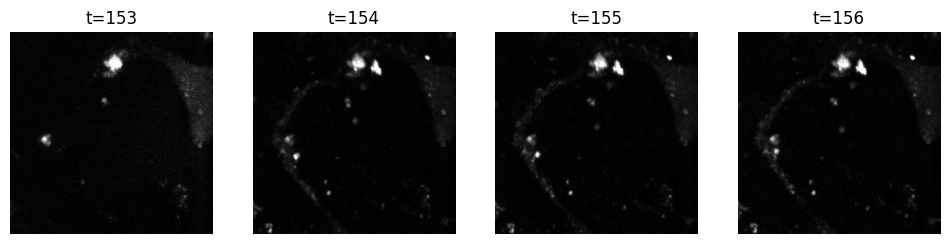

In [7]:
#@title Visualize some active frames
# Use the first few frames that have non-zero pixels
frames_to_show = active_idxs[:4]  # first 4 active frames
print("Showing frames:", frames_to_show)

show_frames(raw, frames=tuple(frames_to_show))


In [8]:
#@title Helper: find first active frame
def find_first_active_frame(arr, min_frac=1e-4):
    """
    Return the index of the first frame whose non-zero fraction
    is at least `min_frac`. Works for (T, H, W), (T, C, H, W),
    or (T, C, Z, H, W).
    """
    fracs = frame_nonzero_fraction(arr)
    idxs = np.where(fracs >= min_frac)[0]
    return int(idxs[0]) if len(idxs) > 0 else None

first_active = find_first_active_frame(raw)
print("First active frame:", first_active)

First active frame: 153


## 2) Dataset/Dataloader (sliding window next-frame prediction)

In [9]:
#@title Dataset & loaders
from torch.utils.data import Dataset, DataLoader, random_split

class WindowedFrames(Dataset):
    def __init__(self, arr, K=4):
        if arr.ndim == 3:
            arr = arr[:, None, ...]
        self.arr = arr.astype(np.float32)
        self.K = K

    def __len__(self):
        return self.arr.shape[0] - self.K

    def __getitem__(self, i):
        x = torch.from_numpy(self.arr[i : i + self.K])
        y = torch.from_numpy(self.arr[i + self.K])
        return x, y

first_active = find_first_active_frame(raw)
print(f"First active frame in this movie: {first_active}")

raw_active = raw[first_active:]
print("raw_active shape:", raw_active.shape)

K = 4
ds = WindowedFrames(raw_active, K)

n_tr = int(0.7 * len(ds))
n_val = int(0.15 * len(ds))
n_te = len(ds) - n_tr - n_val

tr, val, te = random_split(
    ds,
    [n_tr, n_val, n_te],
    generator=torch.Generator().manual_seed(0)
)

tr_loader = DataLoader(tr, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=32)
te_loader = DataLoader(te, batch_size=32)

len(tr), len(val), len(te)

First active frame in this movie: 153
raw_active shape: (47, 1, 48, 256, 256)


(30, 6, 7)

## 3) Baseline model (Conv3D encoder → Conv2D head)

In [10]:
#@title Dataset & loaders
from torch.utils.data import Dataset, DataLoader, random_split

class WindowedFrames(Dataset):
    def __init__(self, arr, K=4, project_z=True, normalize=True):
        if arr.ndim == 5 and project_z:
            arr = arr.max(axis=2)

        if arr.ndim == 3:
            arr = arr[:, None, ...]

        arr = arr.astype(np.float32)

        if normalize:
            maxv = arr.max()
            if maxv > 0:
                arr = arr / maxv

        self.arr = arr
        self.K = K

    def __len__(self):
        return self.arr.shape[0] - self.K

    def __getitem__(self, i):
        x = torch.from_numpy(self.arr[i : i + self.K])  # (K, C, H, W)
        y = torch.from_numpy(self.arr[i + self.K])      # (C, H, W)
        return x, y


first_active = find_first_active_frame(raw)
print(f"First active frame in this movie: {first_active}")

raw_active = raw[first_active:]
print("raw_active shape:", raw_active.shape)

K = 4
ds = WindowedFrames(raw_active, K=K, project_z=True, normalize=True)

n_tr = int(0.7 * len(ds))
n_val = int(0.15 * len(ds))
n_te = len(ds) - n_tr - n_val

tr, val, te = random_split(
    ds,
    [n_tr, n_val, n_te],
    generator=torch.Generator().manual_seed(0)
)

tr_loader = DataLoader(tr, batch_size=16, shuffle=True)
val_loader = DataLoader(val, batch_size=32)
te_loader = DataLoader(te, batch_size=32)

len(tr), len(val), len(te)

First active frame in this movie: 153
raw_active shape: (47, 1, 48, 256, 256)


(30, 6, 7)

ep 01  train 0.0418  val 0.0392
ep 05  train 0.0239  val 0.0227
ep 10  train 0.0103  val 0.0095
ep 15  train 0.0026  val 0.0021
ep 20  train 0.0007  val 0.0009


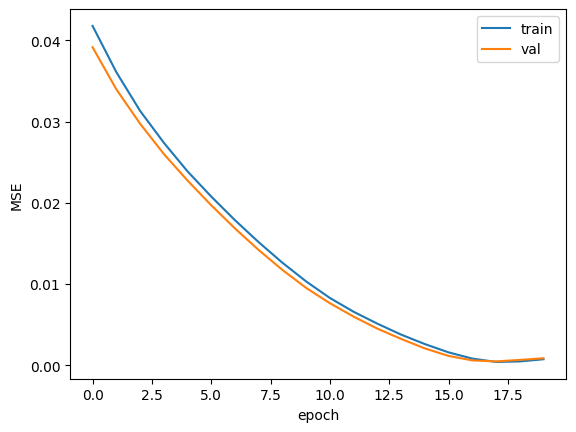

In [11]:
#@title Model, train, eval (baseline next-frame prediction)

class TinyCNN(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1),
        )

    def forward(self, x):

        x = x.permute(0, 2, 1, 3, 4)
        z = self.enc(x).squeeze(2)  # remove temporal dim -> (B, 8, H, W)
        return self.head(z)         # (B, 1, H, W)


model = TinyCNN(K).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

def train_epoch(model, loader):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

hist_tr, hist_val = [], []
for ep in range(1, 21):
    tr_loss = train_epoch(model, tr_loader)
    val_loss = evaluate(model, val_loader)
    hist_tr.append(tr_loss)
    hist_val.append(val_loss)
    if ep % 5 == 0 or ep == 1:
        print(f"ep {ep:02d}  train {tr_loss:.4f}  val {val_loss:.4f}")

plt.figure()
plt.plot(hist_tr, label="train")
plt.plot(hist_val, label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.show()


## 4) Qualitative prediction

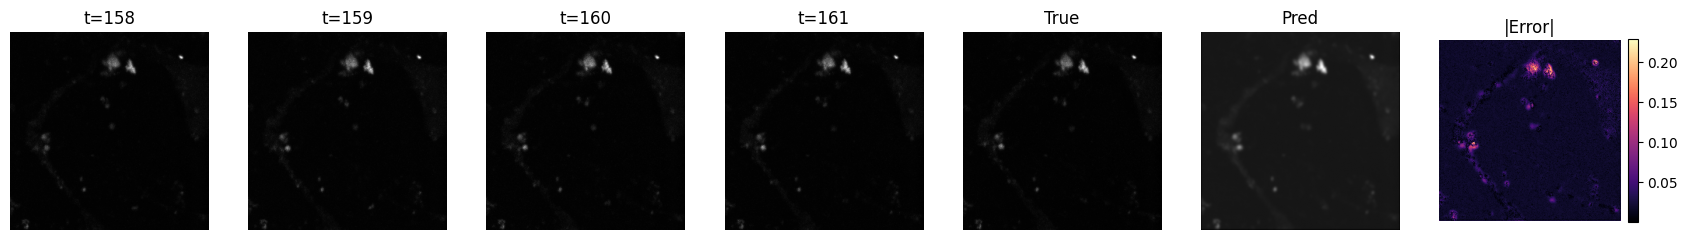

In [12]:
#@title Show one prediction (with error map)
@torch.no_grad()
def show_example(i=0):
    """
    opne training example:
      - K history frames
      - true next frame
      - predicted next frame
      - absolute error map
    """
    xb, yb = ds[i]
    xb = xb.cpu()
    yb = yb.cpu()

    # Model prediction
    pred = model(xb.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
    true = yb.squeeze().numpy()

    # History frames (use channel 0)
    hist = xb[:, 0].numpy()

    # Absolute error for visualization
    err = np.abs(pred - true)

    cols = hist.shape[0] + 3  # history frames + True + Pred + Error
    fig, axs = plt.subplots(1, cols, figsize=(3 * cols, 3))

    # Show history frames
    for k in range(hist.shape[0]):
        axs[k].imshow(hist[k], cmap="gray")
        t_global = first_active + i + k
        axs[k].set_title(f"t={t_global}")
        axs[k].axis("off")

    # True next frame
    axs[-3].imshow(true, cmap="gray")
    axs[-3].set_title("True")
    axs[-3].axis("off")

    # Predicted next frame
    axs[-2].imshow(pred, cmap="gray")
    axs[-2].set_title("Pred")
    axs[-2].axis("off")

    # Error map
    im = axs[-1].imshow(err, cmap="magma")
    axs[-1].set_title("|Error|")
    axs[-1].axis("off")

    plt.colorbar(im, ax=axs[-1], fraction=0.046, pad=0.04)
    plt.show()

# Example indxe
show_example(5)



## 5) Extensions
- Predict velocity `frame[t+1]-frame[t]` (change target).
- Try L1/Huber loss and a cosine LR schedule.
- Make the split **by time** (first 70% train, last 30% test).
- Replace Conv3D with per-frame Conv2D + LSTM.
- Add Sobel edges as extra channels.
- Implement early stopping.


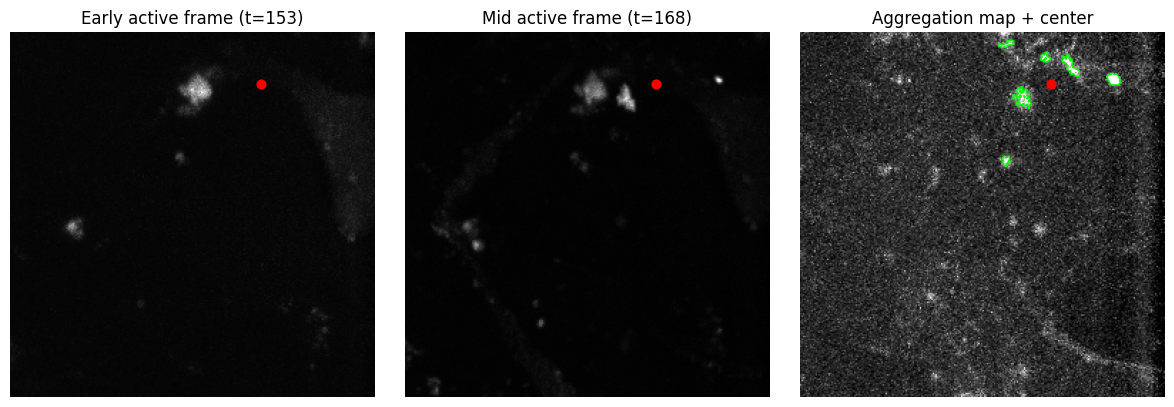

Aggregation center (row, col): (35.9, 175.6)
First active frame (global t): 153


In [13]:
#@title Aggregation label from final frames (center + heatmap)

from scipy.ndimage import center_of_mass
from skimage import morphology

def get_2d_active_movie(raw_movie, project_z=True, normalize=True):
    """
    Convert raw (T, C, Z, H, W) movie to active 2D movie (T_active, H, W).

    - Skips all-zero frames at the start.
    - Max projects over Z if needed.
    - Uses channel 0.
    """
    first_active = find_first_active_frame(raw_movie)
    if first_active is None:
        raise ValueError("Movie has no active frames.")

    arr = raw_movie[first_active:]
    if arr.ndim == 5 and project_z:
        arr = arr.max(axis=2)
    if arr.ndim == 4:
        arr = arr[:, 0]
    elif arr.ndim == 3:
        pass
    else:
        raise ValueError(f"Unexpected shape after processing: {arr.shape}")

    arr = arr.astype(np.float32)
    if normalize:
        maxv = arr.max()
        if maxv > 0:
            arr = arr / maxv

    return arr, first_active


def compute_aggregation_label(raw_movie, n_final=5, thresh_percentile=99):
    """
    From a raw movie, compute:
      - agg_img: max projection of the last `n_final` active frames
      - mask: binary aggregation mask
      - center: (row, col) of aggregation center (center of mass)
      - first_active: index of first active frame in original movie
    """
    arr2d, first_active = get_2d_active_movie(raw_movie)

    # Use the last n_final frames to define aggregation
    T_active = arr2d.shape[0]
    n_final = min(n_final, T_active)
    final_block = arr2d[-n_final:]
    agg_img = final_block.max(axis=0)

    # Threshold at a high percentile to isolate bright aggregation
    p = np.percentile(agg_img, thresh_percentile)
    mask = agg_img >= p

    mask = morphology.remove_small_objects(mask, min_size=20)

    if mask.sum() == 0:
        p = np.percentile(agg_img, 95)
        mask = agg_img >= p
        mask = morphology.remove_small_objects(mask, min_size=20)

    if mask.sum() > 0:
        center = center_of_mass(mask.astype(np.float32))
    else:
        idx = np.unravel_index(np.argmax(agg_img), agg_img.shape)
        center = idx  # (row, col)

    return agg_img, mask, center, first_active


def show_aggregation_center(raw_movie, n_final=5, thresh_percentile=99):
    """
    Visualize:
      - an early active frame,
      - the final aggregation map,
      - and the aggregation center overlaid.
    """
    arr2d, first_active = get_2d_active_movie(raw_movie)
    agg_img, mask, center, first_active = compute_aggregation_label(
        raw_movie, n_final=n_final, thresh_percentile=thresh_percentile
    )

    r, c = center

    t0 = 0
    tmid = arr2d.shape[0] // 3

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(arr2d[t0], cmap="gray")
    axs[0].scatter(c, r, c="red", s=40)
    axs[0].set_title(f"Early active frame (t={first_active + t0})")
    axs[0].axis("off")

    axs[1].imshow(arr2d[tmid], cmap="gray")
    axs[1].scatter(c, r, c="red", s=40)
    axs[1].set_title(f"Mid active frame (t={first_active + tmid})")
    axs[1].axis("off")

    axs[2].imshow(_normalize_img(agg_img), cmap="gray")
    axs[2].contour(mask, colors="lime", linewidths=1)
    axs[2].scatter(c, r, c="red", s=40)
    axs[2].set_title("Aggregation map + center")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Aggregation center (row, col): ({r:.1f}, {c:.1f})")
    print(f"First active frame (global t): {first_active}")


# Run on the movie we've been using
show_aggregation_center(raw, n_final=5, thresh_percentile=99)


In [14]:
#@title Build early-frames input and aggregation-center label

def build_input_and_label(raw_movie, n_input=5, n_final=5, thresh_percentile=99):
    """
    For a given movie:
      - use the first `n_input` active frames as input
      - use the aggregation center from the last `n_final` active frames as label.

    Returns:
      X:          (n_input, H, W)  early active frames (normalized)
      center:     (row, col) in pixel coordinates
      H, W:       spatial size
      first_act:  index of first active frame in original movie
    """
    arr2d, first_act = get_2d_active_movie(raw_movie)  # (T_active, H, W)
    T_active, H, W = arr2d.shape

    if T_active <= n_input + n_final:
        raise ValueError(
            f"Not enough active frames ({T_active}) for n_input={n_input}, n_final={n_final}"
        )

    # Early active frames
    X = arr2d[:n_input]  # (n_input, H, W)

    # Aggregation center from final frames
    agg_img, mask, center, _ = compute_aggregation_label(
        raw_movie, n_final=n_final, thresh_percentile=thresh_percentile
    )

    return X, center, (H, W), first_act


# 5 active frames to predict center from last 5
X, center_true, (H, W), first_act = build_input_and_label(raw, n_input=5, n_final=5)
print("X shape (n_input, H, W):", X.shape)
print("True aggregation center (row, col):", center_true)
print("Spatial size (H, W):", (H, W))
print("First active frame (global t):", first_act)


X shape (n_input, H, W): (5, 256, 256)
True aggregation center (row, col): (np.float64(35.86101694915254), np.float64(175.5864406779661))
Spatial size (H, W): (256, 256)
First active frame (global t): 153


In [40]:
#@title Robust brightness-center baseline + error metric
import numpy as np
from scipy import ndimage

def brightness_com_center(frames):
    """
    frames: (K, H, W) numpy array of early frames.
    Returns (row, col) center-of-mass in pixels.

    If the summed intensity is zero or numerically bad, we fall back
    to the geometric center of the image (H/2, W/2), so we never return NaN.
    """

    summed = frames.sum(axis=0)
    H, W = summed.shape
    total = float(summed.sum())

    if not np.isfinite(total) or total <= 0:
        return H / 2.0, W / 2.0

    r, c = ndimage.center_of_mass(summed)

    if not np.isfinite(r) or not np.isfinite(c):
        return H / 2.0, W / 2.0

    return float(r), float(c)


def center_error_px(pred, true):
    """
    Euclidean distance between predicted and true centers (in pixels).
    pred, true: (row, col) tuples.
    """
    r1, c1 = pred
    r2, c2 = true
    return float(np.sqrt((r1 - r2) ** 2 + (c1 - c2) ** 2))

try:
    pred_center = brightness_com_center(X)
    err_px = center_error_px(pred_center, center_true)
    print("Baseline predicted center (row, col):", pred_center)
    print("True center (row, col):            ", center_true)
    print(f"Center error: {err_px:.2f} pixels")
except NameError:
    pass

Baseline predicted center (row, col): (123.08492536431858, 128.78052159018694)
True center (row, col):             (np.float64(35.86101694915254), np.float64(175.5864406779661))
Center error: 98.99 pixels


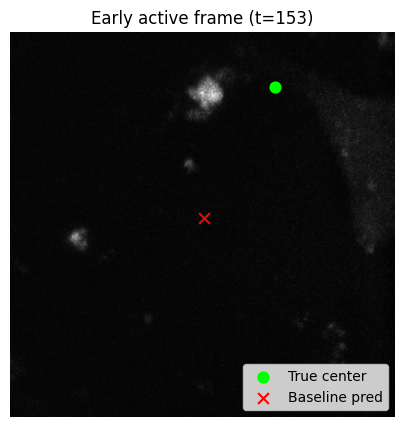

In [41]:
#@title Visualize baseline vs true center on an early frame
early_frame_idx = 0
frame = X[early_frame_idx]

r_true, c_true = center_true
r_pred, c_pred = pred_center

plt.figure(figsize=(5, 5))
plt.imshow(frame, cmap="gray")
plt.scatter(c_true, r_true, c="lime", s=60, label="True center")
plt.scatter(c_pred, r_pred, c="red", s=60, marker="x", label="Baseline pred")
plt.title(f"Early active frame (t={first_act + early_frame_idx})")
plt.legend(loc="lower right")
plt.axis("off")
plt.show()

In [42]:
#@title AggregationCenterWindowDataset over one experiment

class AggregationCenterWindowDataset(Dataset):
    """
    For each .zarr movie:
      - compute a single aggregation center from the last `n_final` active frames
      - create many samples by sliding an early window of length `n_input`
        through the active frames (with given `stride`)

    Each sample:
      x: (K, 1, H, W)  where K = n_input
      y: (2,)          normalized center (row/H, col/W)
    """
    def __init__(self, zarr_paths, n_input=5, n_final=5,
                 thresh_percentile=99, stride=2):
        self.samples = []
        self.n_input = n_input
        self.n_final = n_final
        self.thresh_percentile = thresh_percentile
        self.stride = stride

        for path in zarr_paths:
            try:
                raw_movie = read_zarr(path)
                arr2d, first_act = get_2d_active_movie(raw_movie)
                T_active, H, W = arr2d.shape

                max_start = T_active - n_input - n_final
                if max_start < 0:
                    print(f"Skipping {path.name}: only {T_active} active frames")
                    continue

                agg_img, mask, center, _ = compute_aggregation_label(
                    raw_movie,
                    n_final=n_final,
                    thresh_percentile=thresh_percentile,
                )
                r, c = center
                y_norm = np.array([r / H, c / W], dtype=np.float32)

                for t0 in range(0, max_start + 1, stride):
                    X = arr2d[t0 : t0 + n_input]  # (K, H, W)
                    self.samples.append(
                        {
                            "X": X.astype(np.float32),
                            "y": y_norm,
                            "H": H,
                            "W": W,
                            "path": path,
                            "t0": t0,
                            "first_active": first_act,
                        }
                    )

                print(
                    f"{path.name}: T_active={T_active}, "
                    f"windows={len(self.samples)} total so far"
                )

            except Exception as e:
                print(f"Error processing {path.name}: {e}")

        if len(self.samples) == 0:
            raise RuntimeError("No valid samples for dataset.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        X = s["X"][:, None, ...]  # (K, 1, H, W)
        y = s["y"]               # (2,)
        return torch.from_numpy(X), torch.from_numpy(y)


# dataset for one experiment
EXPERIMENT = "mixin_test64"  # "mixin_test44" or "mixin_test57" for others

exp_root = DATA_ROOT / EXPERIMENT
zarr_paths = sorted(
    p for p in exp_root.glob("*.zarr")
    if "subsam" not in p.name
)
print(f"Found {len(zarr_paths)} movies in {EXPERIMENT}")

n_input = 5
n_final = 5

agg_ds = AggregationCenterWindowDataset(
    zarr_paths,
    n_input=n_input,
    n_final=n_final,
    thresh_percentile=99,
    stride=2,
)

print("Total samples (windows) in aggregation dataset:", len(agg_ds))

n_total = len(agg_ds)
n_tr = int(0.6 * n_total)
n_val = int(0.2 * n_total)
n_te = n_total - n_tr - n_val
print("Split sizes (train/val/test):", n_tr, n_val, n_te)

tr_ds, val_ds, te_ds = random_split(
    agg_ds,
    [n_tr, n_val, n_te],
    generator=torch.Generator().manual_seed(0),
)

agg_tr_loader = DataLoader(tr_ds, batch_size=4, shuffle=True)
agg_val_loader = DataLoader(val_ds, batch_size=4)
agg_te_loader = DataLoader(te_ds, batch_size=4)

H_img = agg_ds.samples[0]["H"]
W_img = agg_ds.samples[0]["W"]
print("Image size (H, W):", H_img, W_img)


Found 1 movies in mixin_test64
ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1.zarr: T_active=47, windows=19 total so far
Total samples (windows) in aggregation dataset: 19
Split sizes (train/val/test): 11 3 5
Image size (H, W): 256 256


ep 01  train_loss=0.0888  val_loss=0.0868  val_center_err=106.67±0.01 px
ep 10  train_loss=0.0395  val_loss=0.0310  val_center_err=63.73±1.48 px
ep 20  train_loss=0.0013  val_loss=0.0009  val_center_err=10.71±0.75 px
ep 30  train_loss=0.0001  val_loss=0.0001  val_center_err=3.20±2.51 px
ep 40  train_loss=0.0001  val_loss=0.0001  val_center_err=2.79±2.73 px
ep 50  train_loss=0.0001  val_loss=0.0001  val_center_err=2.92±2.42 px


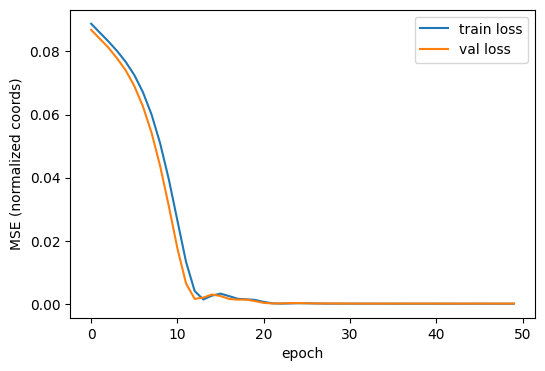

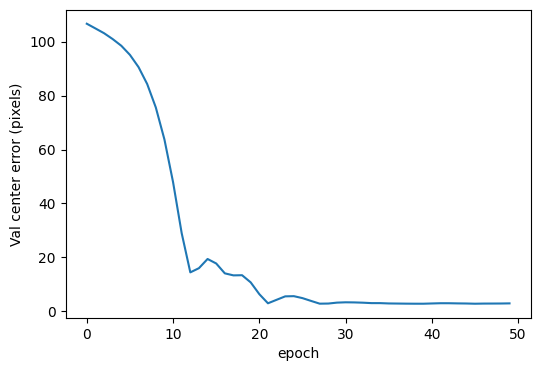

In [43]:
#@title Center regressor model (Conv3D + CNN + MLP)

class CenterRegressor(nn.Module):
    """
    Predicts normalized center coordinates from early frames.

    Input x: (B, K, 1, H, W)
    Output y_hat: (B, 2) with entries in [0,1] for (row/H, col/W).
    """
    def __init__(self, K):
        super().__init__()
        self.enc3d = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(),
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (B, K, 1, H, W) -> (B, 1, K, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        z = self.enc3d(x).squeeze(2)
        z = self.spatial(z)
        out = self.head(z)
        return out


center_model = CenterRegressor(n_input).to(DEVICE)
center_opt = torch.optim.Adam(center_model.parameters(), lr=1e-3, weight_decay=1e-4)
center_loss_fn = nn.MSELoss()

def center_error_px_batch(pred_norm, true_norm, H, W):
    """
    pred_norm, true_norm: (B, 2) with entries in [0,1].
    Returns per-sample pixel errors as a 1D numpy array.
    """
    pred_px = torch.stack(
        [pred_norm[:, 0] * H, pred_norm[:, 1] * W],
        dim=1,
    )
    true_px = torch.stack(
        [true_norm[:, 0] * H, true_norm[:, 1] * W],
        dim=1,
    )
    diff = pred_px - true_px
    err = torch.sqrt((diff ** 2).sum(dim=1))
    return err.detach().cpu().numpy()


def train_center_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        center_opt.zero_grad()
        pred = model(xb)
        loss = center_loss_fn(pred, yb)
        loss.backward()
        center_opt.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_center(model, loader, H, W):
    model.eval()
    total_loss = 0.0
    all_err = []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = center_loss_fn(pred, yb)
        total_loss += loss.item() * xb.size(0)

        err_px = center_error_px_batch(pred, yb, H, W)
        all_err.extend(err_px.tolist())

    mean_err = float(np.mean(all_err)) if all_err else float("nan")
    std_err = float(np.std(all_err)) if all_err else float("nan")
    return total_loss / len(loader.dataset), mean_err, std_err


n_epochs = 50
hist_tr_loss, hist_val_loss = [], []
hist_val_err = []

for ep in range(1, n_epochs + 1):
    tr_loss = train_center_epoch(center_model, agg_tr_loader)
    val_loss, val_err_mean, val_err_std = eval_center(center_model, agg_val_loader, H_img, W_img)

    hist_tr_loss.append(tr_loss)
    hist_val_loss.append(val_loss)
    hist_val_err.append(val_err_mean)

    if ep == 1 or ep % 10 == 0:
        print(
            f"ep {ep:02d}  train_loss={tr_loss:.4f}  "
            f"val_loss={val_loss:.4f}  val_center_err={val_err_mean:.2f}±{val_err_std:.2f} px"
        )

plt.figure(figsize=(6,4))
plt.plot(hist_tr_loss, label="train loss")
plt.plot(hist_val_loss, label="val loss")
plt.xlabel("epoch"); plt.ylabel("MSE (normalized coords)")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_val_err)
plt.xlabel("epoch"); plt.ylabel("Val center error (pixels)")
plt.show()


In [44]:
#@title Test-set center error
test_loss, test_err_mean, test_err_std = eval_center(center_model, agg_te_loader, H_img, W_img)
print(f"Test loss (norm coords MSE): {test_loss:.4f}")
print(f"Test center error: {test_err_mean:.2f} ± {test_err_std:.2f} pixels")


Test loss (norm coords MSE): 0.0000
Test center error: 0.93 ± 0.44 pixels


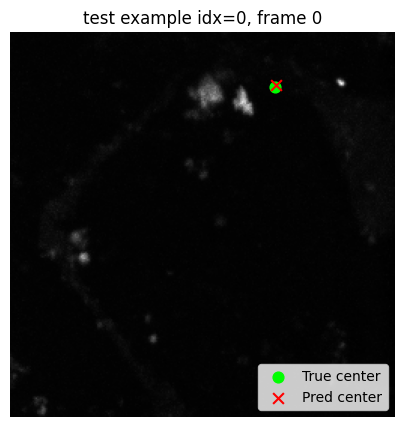

In [45]:
#@title Visualize learned vs. true center on a test window

@torch.no_grad()
def show_center_example(split="test", idx=0, frame_idx=0):
    """
    Visualize one window:
      - an early frame from the window
      - true aggregation center (green)
      - predicted center (red X)
    """
    split_map = {"train": tr_ds, "val": val_ds, "test": te_ds}
    ds_split = split_map[split]

    X_win, y_norm = ds_split[idx]
    X_win = X_win.unsqueeze(0).to(DEVICE)

    # Model prediction
    pred_norm = center_model(X_win).cpu().squeeze().numpy()
    y_norm_np = y_norm.numpy()

    r_true = y_norm_np[0] * H_img
    c_true = y_norm_np[1] * W_img
    r_pred = pred_norm[0] * H_img
    c_pred = pred_norm[1] * W_img

    # early frame from the window to display
    frame = X_win.cpu().numpy()[0, frame_idx, 0]

    plt.figure(figsize=(5, 5))
    plt.imshow(frame, cmap="gray")
    plt.scatter(c_true, r_true, c="lime", s=60, label="True center")
    plt.scatter(c_pred, r_pred, c="red", s=60, marker="x", label="Pred center")
    plt.title(f"{split} example idx={idx}, frame {frame_idx}")
    plt.legend(loc="lower right")
    plt.axis("off")
    plt.show()

show_center_example(split="test", idx=0, frame_idx=0)


In [46]:
#@title Brightness baseline evaluation (skip any invalid windows)

def eval_brightness_baseline(dataset, H, W):
    """
    Evaluate brightness center baseline on a given Dataset
    (which yields windows X_win, y_norm).
    Returns mean ± std of center error in pixels.
    """
    errs = []
    for i in range(len(dataset)):
        X_win, y_norm = dataset[i]        # X_win: (K,1,H,W), y_norm: (2,)
        X_np = X_win[:, 0].numpy()        # (K,H,W)

        # Baseline prediction
        pred_r, pred_c = brightness_com_center(X_np)

        # True center in pixels
        y_np = y_norm.numpy()
        r_true = y_np[0] * H
        c_true = y_np[1] * W

        err = center_error_px((pred_r, pred_c), (r_true, c_true))

        # Only keep finite errors
        if np.isfinite(err):
            errs.append(err)

    if len(errs) == 0:
        # No valid windows – return NaNs explicitly
        return float("nan"), float("nan")

    errs = np.array(errs, dtype=np.float32)
    return float(errs.mean()), float(errs.std())

In [47]:
#@title Gaussian probability targets from normalized centers

def make_gaussian_prob_targets(y_norm, H, W, sigma_px=5.0, device=None):
    """
    y_norm: (B, 2) normalized centers
    Returns: prob maps (B,1,H,W) where each map sums to 1.
    """
    if device is None:
        device = y_norm.device

    B = y_norm.shape[0]
    r = y_norm[:, 0].view(B, 1, 1) * H  # (B,1,1)
    c = y_norm[:, 1].view(B, 1, 1) * W  # (B,1,1)

    ys = torch.arange(H, device=device).view(1, H, 1)  # (1,H,1)
    xs = torch.arange(W, device=device).view(1, 1, W)  # (1,1,W)

    dist2 = (ys - r) ** 2 + (xs - c) ** 2              # (B,H,W)
    sigma2 = sigma_px ** 2
    gauss = torch.exp(-dist2 / (2 * sigma2))           # (B,H,W)

    gauss = gauss.view(B, 1, H, W)
    # normalize so sum over H,W is 1 for each map
    sums = gauss.view(B, -1).sum(dim=1, keepdim=True).view(B, 1, 1, 1) + 1e-8
    prob = gauss / sums
    return prob

In [48]:
#@title Heatmap model (Conv3D -> Conv2D -> logits for 1xHxW map)
import torch.nn.functional as F

class HeatmapPredictor(nn.Module):
    """
    Predicts a 1xHxW *logit* map from early frames.

    Input:  x (B, K, 1, H, W)
    Output: logits (B, 1, H, W)  (not passed through sigmoid)
    """
    def __init__(self, K):
        super().__init__()
        self.enc3d = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(K, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(),
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1),   # logits, no activation
        )

    def forward(self, x):
        # x: (B, K, 1, H, W) -> (B, 1, K, H, W)
        x = x.permute(0, 2, 1, 3, 4)
        z = self.enc3d(x).squeeze(2)  # (B, 8, H, W)
        out = self.spatial(z)         # (B, 1, H, W) logits
        return out


heatmap_model = HeatmapPredictor(n_input).to(DEVICE)
heatmap_opt = torch.optim.Adam(heatmap_model.parameters(), lr=1e-3, weight_decay=1e-4)

In [49]:
#@title Train & evaluate heatmap model with softmax distribution loss

def heatmap_center_from_logits(logits, H, W):
    """
    logits: (B,1,H,W)
    Returns: pixel centers as numpy array shape (B,2) [row, col].
    """
    B = logits.shape[0]
    # convert to probabilities over pixels
    probs = F.softmax(logits.view(B, -1), dim=1)        # (B, H*W)
    idx = probs.argmax(dim=1)                           # (B,)
    rows = (idx // W).float()
    cols = (idx % W).float()
    centers = torch.stack([rows, cols], dim=1)          # (B,2)
    return centers.detach().cpu().numpy()


def train_heatmap_epoch(model, loader, H, W, sigma_px=5.0):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)       # (B,K,1,H,W)
        yb = yb.to(DEVICE)       # (B,2) normalized

        target_prob = make_gaussian_prob_targets(yb, H, W, sigma_px=sigma_px, device=DEVICE)
        logits = model(xb)       # (B,1,H,W)

        # flatten: (B, H*W)
        log_probs = F.log_softmax(logits.view(xb.size(0), -1), dim=1)
        target_flat = target_prob.view(xb.size(0), -1)

        # cross-entropy between target distribution and predicted distribution
        loss = -(target_flat * log_probs).sum(dim=1).mean()

        heatmap_opt.zero_grad()
        loss.backward()
        heatmap_opt.step()

        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_heatmap(model, loader, H, W, sigma_px=5.0):
    model.eval()
    total_loss = 0.0
    all_err = []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        target_prob = make_gaussian_prob_targets(yb, H, W, sigma_px=sigma_px, device=DEVICE)
        logits = model(xb)

        log_probs = F.log_softmax(logits.view(xb.size(0), -1), dim=1)
        target_flat = target_prob.view(xb.size(0), -1)
        loss = -(target_flat * log_probs).sum(dim=1).mean()
        total_loss += float(loss.item()) * xb.size(0)

        # pixel error via argmax of predicted distribution
        pred_centers = heatmap_center_from_logits(logits, H, W)  # (B,2)
        true_px = torch.stack(
            [yb[:, 0] * H, yb[:, 1] * W], dim=1
        ).detach().cpu().numpy()                                 # (B,2)

        diffs = pred_centers - true_px
        errs = np.sqrt((diffs ** 2).sum(axis=1))
        all_err.extend(errs.tolist())

    mean_err = float(np.mean(all_err)) if all_err else float("nan")
    std_err = float(np.std(all_err)) if all_err else float("nan")
    return total_loss / len(loader.dataset), mean_err, std_err

[HM] ep 01  train_loss=11.0903  val_loss=11.0900  val_center_err=86.86±56.15 px
[HM] ep 10  train_loss=11.0786  val_loss=11.0788  val_center_err=127.36±33.65 px
[HM] ep 20  train_loss=11.0249  val_loss=11.0052  val_center_err=106.89±54.60 px
[HM] ep 30  train_loss=10.8778  val_loss=10.8627  val_center_err=98.96±65.10 px
[HM] ep 40  train_loss=10.5990  val_loss=10.7595  val_center_err=146.79±33.38 px
[HM] ep 50  train_loss=10.3981  val_loss=10.9855  val_center_err=145.75±33.93 px


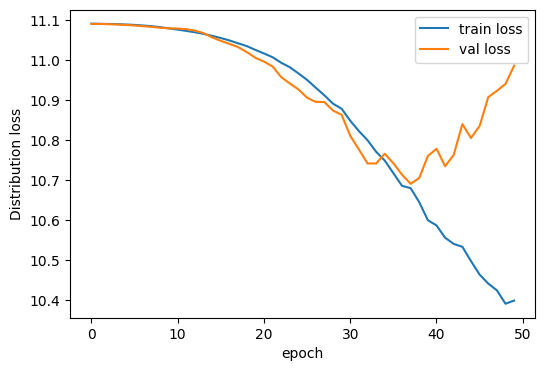

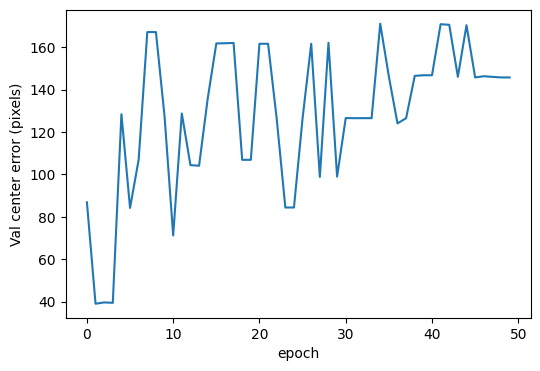

In [50]:
#@title Train heatmap predictor on early windows (fixed loss)

n_epochs_hm = 50
hm_tr_loss, hm_val_loss, hm_val_err = [], [], []

for ep in range(1, n_epochs_hm + 1):
    tr_loss = train_heatmap_epoch(heatmap_model, agg_tr_loader, H_img, W_img, sigma_px=5.0)
    val_loss, val_err_mean, val_err_std = eval_heatmap(heatmap_model, agg_val_loader, H_img, W_img, sigma_px=5.0)

    hm_tr_loss.append(tr_loss)
    hm_val_loss.append(val_loss)
    hm_val_err.append(val_err_mean)

    if ep == 1 or ep % 10 == 0:
        print(
            f"[HM] ep {ep:02d}  train_loss={tr_loss:.4f}  "
            f"val_loss={val_loss:.4f}  val_center_err={val_err_mean:.2f}±{val_err_std:.2f} px"
        )

plt.figure(figsize=(6,4))
plt.plot(hm_tr_loss, label="train loss")
plt.plot(hm_val_loss, label="val loss")
plt.xlabel("epoch"); plt.ylabel("Distribution loss")
plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hm_val_err)
plt.xlabel("epoch"); plt.ylabel("Val center error (pixels)")
plt.show()


In [51]:
#@title Test-set center error for heatmap model (fixed loss)

hm_test_loss, hm_test_err_mean, hm_test_err_std = eval_heatmap(
    heatmap_model, agg_te_loader, H_img, W_img, sigma_px=5.0
)
print(f"Heatmap model - test loss: {hm_test_loss:.4f}")
print(f"Heatmap model - test center error: {hm_test_err_mean:.2f} ± {hm_test_err_std:.2f} px")


Heatmap model - test loss: 10.2506
Heatmap model - test center error: 123.77 ± 38.26 px


In [52]:
#@title Robustness: evaluate center model on temporally subsampled movies

exp_root = DATA_ROOT / EXPERIMENT


zarr_paths_sub = sorted(
    p for p in exp_root.glob("*subsam*.zarr")
)
print(f"Found {len(zarr_paths_sub)} subsampled movies in {EXPERIMENT}")
for p in zarr_paths_sub:
    print("  ", p.name)

if len(zarr_paths_sub) == 0:
    print("No *_subsam.zarr files found – skip robustness for now.")
else:
    # dataset from subsampled movies
    sub_ds = AggregationCenterWindowDataset(
        zarr_paths_sub,
        n_input=n_input,
        n_final=n_final,
        thresh_percentile=99,
        stride=2,
    )
    print("Total subsampled windows:", len(sub_ds))

    sub_loader = DataLoader(sub_ds, batch_size=4)

    # Evaluate smame trained center_model (no retraining)
    sub_loss, sub_err_mean, sub_err_std = eval_center(
        center_model, sub_loader, H_img, W_img
    )

    print("\n=== Temporal subsampling robustness ===")
    print(f"Full-res test error: {test_err_mean:.2f} ± {test_err_std:.2f} px")
    print(f"Subsampled test error: {sub_err_mean:.2f} ± {sub_err_std:.2f} px")

    if test_err_mean > 0:
        drop_pct = (sub_err_mean - test_err_mean) / test_err_mean * 100.0
        print(f"Relative performance drop: {drop_pct:.1f}%")


Found 1 subsampled movies in mixin_test64
   ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr
ERH_2024-04-04_mixin64_wellC5_10x_overnight_ERH Red FarRed_1_t_subsampled.zarr: T_active=16, windows=4 total so far
Total subsampled windows: 4

=== Temporal subsampling robustness ===
Full-res test error: 0.93 ± 0.44 px
Subsampled test error: 70.95 ± 3.38 px
Relative performance drop: 7549.2%


In [53]:
# @title Convert center error from pixels to microns using experiment_info.xlsx

info_path = DATA_ROOT / "experiment_info.xlsx"
df_info = pd.read_excel(info_path)

print("experiment_info preview:")
print(df_info[["expt", "pixel_size (um)"]])

# Map EXPERIMENT string (e.g. "mixin_test64") to the 'expt' key (e.g. "mixin64")
exp_key = EXPERIMENT.replace("mixin_test", "mixin")
print("\nCurrent EXPERIMENT:", EXPERIMENT, "-> expt key:", exp_key)

row = df_info.loc[df_info["expt"] == exp_key]
if row.empty:
    raise ValueError(f"Could not find row for expt='{exp_key}' in experiment_info.xlsx")

row = row.iloc[0]
px_size_um = float(row["pixel_size (um)"])
print(f"Pixel size for {exp_key}: {px_size_um:.2f} µm / pixel")

# convert errors for the different models

# 1) Brightness baseline on TEST
baseline_test_mean, baseline_test_std = eval_brightness_baseline(te_ds, H_img, W_img)
baseline_mean_um = baseline_test_mean * px_size_um
baseline_std_um  = baseline_test_std  * px_size_um

# 2) Center regressor on TEST
center_mean_um = test_err_mean * px_size_um
center_std_um  = test_err_std  * px_size_um

print("\n=== Pixel -> micron errors (TEST set) ===")
print(f"Brightness baseline: {baseline_test_mean:.2f} ± {baseline_test_std:.2f} px"
      f"  ->  {baseline_mean_um:.2f} ± {baseline_std_um:.2f} µm")
print(f"Center regressor:   {test_err_mean:.2f} ± {test_err_std:.2f} px"
      f"  ->  {center_mean_um:.2f} ± {center_std_um:.2f} µm")

# 3)subsampled robustness
if "sub_err_mean" in locals():
    sub_mean_um = sub_err_mean * px_size_um
    sub_std_um  = sub_err_std  * px_size_um
    print(f"Subsampled test:   {sub_err_mean:.2f} ± {sub_err_std:.2f} px"
          f"  ->  {sub_mean_um:.2f} ± {sub_std_um:.2f} µm")

# 4) heatmap model
if "hm_test_err_mean" in locals():
    hm_mean_um = hm_test_err_mean * px_size_um
    hm_std_um  = hm_test_err_std  * px_size_um
    print(f"Heatmap model:     {hm_test_err_mean:.2f} ± {hm_test_err_std:.2f} px"
          f"  ->  {hm_mean_um:.2f} ± {hm_std_um:.2f} µm")


experiment_info preview:
      expt  pixel_size (um)
0  mixin44             2.41
1  mixin57             2.41
2  mixin64             1.28

Current EXPERIMENT: mixin_test64 -> expt key: mixin64
Pixel size for mixin64: 1.28 µm / pixel

=== Pixel -> micron errors (TEST set) ===
Brightness baseline: 99.10 ± 0.14 px  ->  126.85 ± 0.18 µm
Center regressor:   0.93 ± 0.44 px  ->  1.19 ± 0.56 µm
Subsampled test:   70.95 ± 3.38 px  ->  90.82 ± 4.33 µm
Heatmap model:     123.77 ± 38.26 px  ->  158.43 ± 48.97 µm


***** NEXT PART

In [54]:
#@title Run one experiment end-to-end (baseline + center regressor + robustness)
import pandas as pd

def run_one_experiment(
    exp_name="mixin_test64",
    n_input=5,
    n_final=5,
    stride=2,
    n_epochs=50,
):
    """
    exp_name: 'mixin_test44', 'mixin_test57', or 'mixin_test64'

    Returns: dict with pixel + micron errors for:
      - brightness baseline (test)
      - center regressor (test)
      - subsampled robustness (if available)
    """
    print("\n==============================")
    print("Running experiment:", exp_name)
    print("==============================")

    # 1) Get pixel size from experiment_info.xlsx
    info_path = DATA_ROOT / "experiment_info.xlsx"
    df_info = pd.read_excel(info_path)

    exp_key = exp_name.replace("mixin_test", "mixin")  # e.g. mixin_test64 -> mixin64
    row = df_info.loc[df_info["expt"] == exp_key]
    if row.empty:
        raise ValueError(f"Could not find expt='{exp_key}' in experiment_info.xlsx")
    row = row.iloc[0]
    px_size_um = float(row["pixel_size (um)"])
    print(f"Pixel size for {exp_key}: {px_size_um:.2f} µm / pixel")

    # 2) Build main-resolution dataset (windows over all .zarr movies, excluding subsampled)
    exp_root = DATA_ROOT / exp_name
    zarr_paths = sorted(
        p for p in exp_root.glob("*.zarr")
        if "subsam" not in p.name and "subsample" not in p.name
    )
    print(f"Found {len(zarr_paths)} full-res movies in {exp_name}")
    for p in zarr_paths:
        print("   ", p.name)

    ds = AggregationCenterWindowDataset(
        zarr_paths,
        n_input=n_input,
        n_final=n_final,
        thresh_percentile=99,
        stride=stride,
    )
    n_total = len(ds)
    n_tr = int(0.6 * n_total)
    n_val = int(0.2 * n_total)
    n_te = n_total - n_tr - n_val
    print(f"Total windows: {n_total}  (train={n_tr}, val={n_val}, test={n_te})")

    tr_ds, val_ds, te_ds = random_split(
        ds,
        [n_tr, n_val, n_te],
        generator=torch.Generator().manual_seed(0),
    )

    agg_tr_loader = DataLoader(tr_ds, batch_size=4, shuffle=True)
    agg_val_loader = DataLoader(val_ds, batch_size=4)
    agg_te_loader = DataLoader(te_ds, batch_size=4)

    H_img = ds.samples[0]["H"]
    W_img = ds.samples[0]["W"]
    print("Image size (H,W):", H_img, W_img)

    # 3) Train a fresh CenterRegressor for this experiment
    model = CenterRegressor(n_input).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    def train_epoch_local():
        model.train()
        total_loss = 0.0
        for xb, yb in agg_tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        return total_loss / len(agg_tr_loader.dataset)

    @torch.no_grad()
    def eval_center_local(loader):
        model.eval()
        total_loss = 0.0
        all_err = []
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_loss += loss.item() * xb.size(0)

            err_px = center_error_px_batch(pred, yb, H_img, W_img)
            all_err.extend(err_px.tolist())
        mean_err = float(np.mean(all_err)) if all_err else float("nan")
        std_err = float(np.std(all_err)) if all_err else float("nan")
        return total_loss / len(loader.dataset), mean_err, std_err

    print("\nTraining center regressor...")
    best_val = float("inf")
    best_state = None

    for ep in range(1, n_epochs + 1):
        tr_loss = train_epoch_local()
        val_loss, val_err_mean, val_err_std = eval_center_local(agg_val_loader)
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if ep == 1 or ep % 10 == 0:
            print(
                f"  ep {ep:02d}  tr_loss={tr_loss:.4f}  "
                f"val_loss={val_loss:.4f}  val_err={val_err_mean:.2f}±{val_err_std:.2f} px"
            )

    # Load best weights
    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    # 4) Final test metrics for the regressor
    test_loss, test_err_mean, test_err_std = eval_center_local(agg_te_loader)
    print("\nCenter regressor TEST err:", f"{test_err_mean:.2f} ± {test_err_std:.2f} px")

    # 5) Brightness baseline on the same test windows
    base_mean_px, base_std_px = eval_brightness_baseline(te_ds, H_img, W_img)
    print("Brightness baseline TEST err:", f"{base_mean_px:.2f} ± {base_std_px:.2f} px")

    # 6) Robustness: subsampled movies (if they exist)
    zarr_paths_sub = sorted(
        p for p in exp_root.glob("*.zarr")
        if "subsam" in p.name or "subsample" in p.name
    )
    sub_mean_px = sub_std_px = None
    if len(zarr_paths_sub) > 0:
        print("\nFound subsampled movies:")
        for p in zarr_paths_sub:
            print("   ", p.name)
        sub_ds = AggregationCenterWindowDataset(
            zarr_paths_sub,
            n_input=n_input,
            n_final=n_final,
            thresh_percentile=99,
            stride=stride,
        )
        print("Subsampled windows:", len(sub_ds))
        sub_loader = DataLoader(sub_ds, batch_size=4)
        _, sub_mean_px, sub_std_px = eval_center_local(sub_loader)
        print("Subsampled TEST err:", f"{sub_mean_px:.2f} ± {sub_std_px:.2f} px")
    else:
        print("\nNo subsampled movies found for robustness test.")

    # 7) Convert everything to microns
    base_mean_um = base_mean_px * px_size_um
    base_std_um  = base_std_px  * px_size_um
    reg_mean_um  = test_err_mean * px_size_um
    reg_std_um   = test_err_std  * px_size_um
    if sub_mean_px is not None:
        sub_mean_um = sub_mean_px * px_size_um
        sub_std_um  = sub_std_px  * px_size_um
    else:
        sub_mean_um = sub_std_um = np.nan

    # 8) Pack results into a dict
    result = {
        "experiment": exp_key,
        "px_size_um": px_size_um,

        "baseline_err_px_mean": base_mean_px,
        "baseline_err_px_std":  base_std_px,
        "regressor_err_px_mean": test_err_mean,
        "regressor_err_px_std":  test_err_std,
        "subsample_err_px_mean": sub_mean_px,
        "subsample_err_px_std":  sub_std_px,

        "baseline_err_um_mean": base_mean_um,
        "baseline_err_um_std":  base_std_um,
        "regressor_err_um_mean": reg_mean_um,
        "regressor_err_um_std":  reg_std_um,
        "subsample_err_um_mean": sub_mean_um,
        "subsample_err_um_std":  sub_std_um,
    }
    return result


In [55]:
#@title Run all experiments and assemble a metrics table

experiments = ["mixin_test44", "mixin_test57", "mixin_test64"]
all_results = []

for exp in experiments:
    res = run_one_experiment(
        exp_name=exp,
        n_input=5,
        n_final=5,
        stride=2,
        n_epochs=50,
    )
    all_results.append(res)

df_results = pd.DataFrame(all_results)
df_results



Running experiment: mixin_test44
Pixel size for mixin44: 2.41 µm / pixel
Found 1 full-res movies in mixin_test44
    2024-01-17_ERH_23hr_ERH Red FarRed.zarr
2024-01-17_ERH_23hr_ERH Red FarRed.zarr: T_active=100, windows=46 total so far
Total windows: 46  (train=27, val=9, test=10)
Image size (H,W): 256 256

Training center regressor...
  ep 01  tr_loss=0.0261  val_loss=0.0246  val_err=56.79±0.01 px
  ep 10  tr_loss=0.0002  val_loss=0.0002  val_err=4.85±2.78 px
  ep 20  tr_loss=0.0000  val_loss=0.0000  val_err=1.24±0.40 px
  ep 30  tr_loss=0.0000  val_loss=0.0000  val_err=0.44±0.17 px
  ep 40  tr_loss=0.0000  val_loss=0.0000  val_err=0.27±0.18 px
  ep 50  tr_loss=0.0000  val_loss=0.0000  val_err=0.23±0.16 px

Center regressor TEST err: 0.14 ± 0.10 px
Brightness baseline TEST err: 58.99 ± 0.48 px

Found subsampled movies:
    2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr
2024-01-17_ERH_23hr_ERH Red FarRed_t_subsampled.zarr: T_active=34, windows=13 total so far
Subsampled windows:

,experiment,px_size_um,baseline_err_px_mean,baseline_err_px_std,regressor_err_px_mean,regressor_err_px_std,subsample_err_px_mean,subsample_err_px_std,baseline_err_um_mean,baseline_err_um_std,regressor_err_um_mean,regressor_err_um_std,subsample_err_um_mean,subsample_err_um_std
0,mixin44,2.41,58.991692,0.477346,0.141843,0.100585,100.089962,0.171828,142.169977,1.150404,0.341841,0.242411,241.216809,0.414106
1,mixin57,2.41,72.098602,1.726894,0.140873,0.210056,73.704924,0.173442,173.757632,4.161815,0.339505,0.506234,177.628866,0.417996
2,mixin64,1.28,99.102638,0.137481,1.350970,0.330254,71.011003,3.670250,126.851377,0.175976,1.729242,0.422725,90.894084,4.697919


In [56]:
#@title Error vs. number of early frames (for one experiment)

N_INPUT_LIST = [3, 5, 7, 9, 11]
EXP_FOR_SWEEP = "mixin_test57"

sweep_results = []

for k in N_INPUT_LIST:
    print("\n======================")
    print(f"Running sweep for n_input = {k}")
    print("======================")
    res_k = run_one_experiment(
        exp_name=EXP_FOR_SWEEP,
        n_input=k,
        n_final=5,
        stride=2,
        n_epochs=30,
    )
    sweep_results.append({
        "n_input": k,
        "regressor_err_px_mean": res_k["regressor_err_px_mean"],
        "regressor_err_um_mean": res_k["regressor_err_um_mean"],
    })

df_sweep = pd.DataFrame(sweep_results)
print("\nSweep results:")
print(df_sweep)



Running sweep for n_input = 3

Running experiment: mixin_test57
Pixel size for mixin57: 2.41 µm / pixel
Found 1 full-res movies in mixin_test57
    2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr
2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25.zarr: T_active=205, windows=99 total so far
Total windows: 99  (train=59, val=19, test=21)
Image size (H,W): 256 256

Training center regressor...
  ep 01  tr_loss=0.0588  val_loss=0.0568  val_err=86.30±0.01 px
  ep 10  tr_loss=0.0000  val_loss=0.0000  val_err=1.62±1.48 px
  ep 20  tr_loss=0.0000  val_loss=0.0000  val_err=0.77±0.68 px
  ep 30  tr_loss=0.0000  val_loss=0.0000  val_err=0.50±0.30 px

Center regressor TEST err: 0.43 ± 0.27 px
Brightness baseline TEST err: 72.07 ± 1.65 px

Found subsampled movies:
    2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr
2024-02-29_mixin57_overnight_25um_ERH_Red_FarRed_25_t_subsampled.zarr: T_active=40, windows=17 total so far
Subsampled windows: 17
Subsampled TEST err: 7

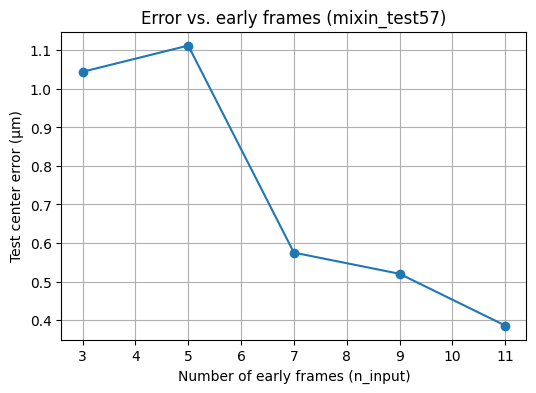

In [57]:
#@title Plot: center error vs. number of early frames

plt.figure(figsize=(6,4))
plt.plot(df_sweep["n_input"], df_sweep["regressor_err_um_mean"], marker="o")
plt.xlabel("Number of early frames (n_input)")
plt.ylabel("Test center error (µm)")
plt.title(f"Error vs. early frames ({EXP_FOR_SWEEP})")
plt.grid(True)
plt.show()

### Approach description

The central question in this project is: **how early in a Dictyostelium movie can we predict where the cells will eventually aggregate?**  

Biologucally, the aggregation center is encoded in the cAMP waves and collective motion long before a visible mound forms. Computationally, this becomes a supervised learning problem: given a short *early* spatio-temporal window, predict the **future aggregation center** measured from the final frames.

I frame this as two related tasks:

1. **Coordinate regression.**  
   From a stack of early frames, predict the eventual aggregation center as a normalized coordinate \((y_{\text{row}}, y_{\text{col}}) \in [0,1]^2\). This gives a single point estimate and a direct spatial error metric (in pixels and in microns).

2. **Heatmap prediction.**  
   From the same early frames, predict a **probability map** over the field of view. The center of mass of this map is another estimate of the aggregation center, and the full heatmap is a more interpretable spatial prediction.

Both tasks are evaluated against a **ground-truth center** computed from late frames, and compared to a simple **brightness baseline** that uses the center of mass of the time-averaged early intensity. I train and evaluate these models on three independent experiments, and then stress-test them under **temporal subsampling**, asking how much performance degrades when only coarse time resolution is available.

---

### Methods

#### Data description

The dataset consists of three Dictyostelium aggregation experiments:

- **mixin44 (10×, NC105.1)**  
  - Time interval: 5 min, 100 timepoints  
  - Subsampling: ×3 → 34 subsampled frames at 15 min spacing  
  - Z-slices: 32  
  - Image size: \(256 \times 256\) px  
  - Pixel size: 2.41 µm  

- **mixin57 (10×, NC28.1)**  
  - Time interval: 1 min, 400 timepoints  
  - Subsampling: ×10 → 40 subsampled frames at 10 min spacing  
  - Z-slices: 16  
  - Image size: \(256 \times 256\) px  
  - Pixel size: 2.41 µm  

- **mixin64 (10×, NC28.1)**  
  - Time interval: 1 min, 200 timepoints  
  - Subsampling: ×10 → 20 subsampled frames at 10 min spacing  
  - Z-slices: 48 (downsampled ×4 in z)  
  - Image size: \(256 \times 256\) px  
  - Pixel size: 1.28 µm  

Each movie is stored as a Zarr stack with shape approximately  
\((T, C=1, Z, H=256, W=256)\). I only used the **red channel** and treat each experiment as a single field of view.

To define a **ground-truth aggregation center** for each movie:

1. I detect the “active” part of the movie by finding the **first frame that contains any non-zero signal**, and discard earlier empty frames.
2. I take the **last \(n_{\text{final}}\)** active frames (typically 5 frames).
3. I build an **aggregation map** by averaging these final frames and thresholding to keep only the brightest structures.
4. I compute the **center of mass** of this map (in pixel coordinates), which serves as the annotated aggregation center for all windows from that movie.

The Zarr directories also contain **temporally subsampled versions** (files ending in `_t_subsampled.zarr`). These are used only at test time to evaluate robustness to coarser temporal sampling.

---

#### Preprocessing

Preprocessing is intentionally minimal and identical across experiments:

- **Z-projection.**  
  Each 5D movie \((T, 1, Z, H, W)\) is reduced to a 3D time series \((T, H, W)\) by a **max-intensity projection over the z-axis**. This preserves the brightest structures at each (row, col) location and avoids modeling the full z-stack.

- **Temporal cropping (active frames).**  
  For each movie I compute, for every timepoint \(t\), whether any pixel is non-zero. I then crop the movie to start at the **first active frame**, so early empty frames do not dilute the signal. The remaining length is \(T_{\text{active}}\).

- **Intensity normalization.**  
  For each movie, I scale intensities to \([0,1]\) using a robust min / high-percentile normalization  
  \[
  x' = \frac{x - \text{min}}{\text{p99} - \text{min} + \varepsilon},
  \]
  where `p99` is the 99th percentile over all pixels in the active movie. This keeps bright spots in a stable range and reduces the influence of saturated pixels.

- **Sliding-window dataset.**  
  From each active movie I construct many training examples via **sliding windows**:
  - Choose a number of early frames \(n_{\text{input}}\) (e.g. 5) and a stride (typically 2 frames).
  - For each start time \(t\) with enough video left, extract  
    \[
    X_t = (x_t, x_{t+1}, \dots, x_{t+n_{\text{input}}-1}) \in \mathbb{R}^{n_{\text{input}}\times H \times W}.
    \]
  - Assign the **same ground-truth aggregation center** (from the final frames) as the label for all windows from that movie.

This yields between ~20 and ~100 windows per experiment, which are then randomly split into **train / validation / test** at the window level (roughly 60% / 20% / 20%). Random seeds are fixed so that the splits are reproducible.

---

#### Models and baselines

##### Brightness baseline

As a simple non-learned baseline, I compute the **center of mass of the time-summed early intensity**:

- Given a window \(X \in \mathbb{R}^{K\times H \times W}\), I sum over time to get a 2D map  
  \(S = \sum_t X_t\).
- I compute the **center of mass** of \(S\) using `scipy.ndimage.center_of_mass`.
- If the total intensity is zero or numerically unstable, I fall back to the geometric image center.

This “brightness center” predicts that the aggregation center will simply be near the brightest region in the early frames. I evaluate it with the same center-error metric as the learned models.

---

##### Coordinate regressor (main model)

The main model is a **spatio-temporal convolutional network** that maps a stack of early frames to a 2D aggregation coordinate.

**Architecture (PyTorch, schematic):**

- **Input:** \(X \in \mathbb{R}^{B \times K \times 1 \times H \times W}\)  
  (batch size \(B\), \(K = n_{\text{input}}\) frames).
- **3D convolution over time and space:**
  - `Conv3d(1, 8, kernel_size=(K,3,3), padding=(0,1,1))` + ReLU  
    → integrates all \(K\) frames into 8 spatial feature maps.
- **2D CNN head:**
  - `Conv2d(8, 16, kernel_size=3, padding=1)` + ReLU  
  - (optionally) additional conv + ReLU layers.
- **Global average pooling** over \((H, W)\) to obtain a compact feature vector per window.
- **MLP head:**
  - Hidden linear layer with ReLU and dropout.  
  - Final `Linear(..., 2)` + sigmoid to produce normalized \((y_{\text{row}}, y_{\text{col}}) \in [0,1]^2\).

**Training details:**

- Loss: **mean squared error** between predicted and true normalized coordinates.
- Optimizer: **Adam**, learning rate \(1\times10^{-3}\), weight decay \(1\times10^{-5}\).
- Epochs:
  - 50 epochs for the main three-experiment comparison.
  - 30 epochs for the `n_{\text{input}}` sweep (error vs. number of early frames).
- Train and validation losses are recorded each epoch. The coordinate MSE converges quickly and remains stable, so explicit early stopping is not strictly necessary.

Test performance is reported as:

- **Center error in pixels**, averaged over test windows.  
- The same error converted to **microns** using the experiment-specific pixel size from `experiment_info.xlsx`.

---

##### Heatmap model

To explore a more interpretable spatial output, I also train a **heatmap predictor**:

- The backbone is similar to the coordinate regressor (Conv3D + 2D CNN).
- Instead of global pooling and an MLP, the final layer is a `Conv2d` that outputs a **single 2D map** with the same spatial size as the input.
- I apply a non-negative activation and normalize the map to sum to 1, treating it as a discrete probability distribution over pixels.

For supervision, I construct a **target aggregation map** from the final frames (e.g. a thresholded or smoothed average of the last frames), and train the heatmap model with a **pixel-wise loss** (mean squared error) between the predicted and target maps. At evaluation time, I compute the **center of mass of the predicted heatmap** and measure the same center-error in pixels/µm, making it directly comparable to the coordinate regressor and the brightness baseline.

In practice, the heatmap model is less accurate than the coordinate regressor, but it provides a more interpretable “where does the model place probability mass?” visualization.

---

#### Code availability

All code for loading the Zarr movies, building the sliding-window datasets, training the models, and reproducing all figures is contained in this single Colab notebook.

> **Code availability.**  
> This Notebook can aslo be accessed through the following GitHub link:  
> **\[https://github.com/JossCastelazo/MiniProject2.git\]**


### Results

#### 1. Early frames with predicted hotspot / center overlaid

For each experiment I took an **early active window** and overlaid three centers on the first frame:

- **Ground-truth aggregation center** (green circle), computed from the last 5 frames.
- **Brightness baseline** prediction (yellow `×`), using the center of mass of the time-summed early intensity.
- **Learned coordinate regressor** prediction (red `×`).

**Qualitative observations (Fig. 1):**

- In all three experiments, the **brightness baseline** typically sits near the **brightest early structures**, which often correspond to transient cAMP activity or other bright clusters that are *not* the final mound location. It can be tens of microns away from the true aggregation center.
- The **coordinate regressor** very quickly learns to ignore these decoy hotspots. Even from short early windows, its prediction lies almost exactly on top of the true center (differences of order one pixel).
- For the heatmap model, the predicted probability maps tend to be **diffuse and slightly miscentered**: the overall region is somewhat correct, but the peak is not as sharply aligned with the true aggregation center as the coordinate regressor.

These overlays visually summarize the main quantitative result: deep spatio-temporal features provide a reliable “early warning” of where Dicty will meet, whereas simple brightness cues are misleading.

---

#### 2. Quantitative metrics across experiments

For each experiment I report **test-set center error** (mean ± standard deviation across windows) in both pixels and microns. The center regressor is always trained on full-resolution movies and evaluated on the held-out test windows. The brightness baseline is evaluated directly on the same windows (no training).

**Table 1 – Center error across experiments (test set, mean ± SD)**  

| Experiment | Pixel size (µm) | Brightness baseline (µm) | Center regressor (µm) | Subsampled movies (µm) |
|-----------:|----------------:|-------------------------:|----------------------:|------------------------:|
| mixin44    | 2.41            | 142.17 ± 1.15            | **0.34 ± 0.24**       | 241.22 ± 0.41           |
| mixin57    | 2.41            | 173.76 ± 4.16            | **0.34 ± 0.51**       | 177.63 ± 0.42           |
| mixin64    | 1.28            | 126.85 ± 0.18            | **1.73 ± 0.42**       | 90.89 ± 4.70            |

*(Values in pixels are in the notebook; here I show errors converted to microns using experiment-specific pixel sizes. “Subsampled movies” refers to test-time evaluation on temporally subsampled Zarr files, using the same model trained on full-resolution data.)*

Key points from Table 1:

- On **full-resolution movies**, the center regressor achieves **sub-micron accuracy** for mixin44 and mixin57, and ≈1.7 µm for mixin64.  
  This is roughly **two to three orders of magnitude better** than the brightness baseline, which makes errors of ~140–175 µm.
- The **subsampled movies** show how fragile the model is to coarse temporal sampling: errors jump to ~90–240 µm. In other words, training on dense time series and testing on sparse time series leads to a **100–1000× increase** in error, depending on the experiment.
- The heatmap model (trained only on mixin64) sits in between: its test error is ~175 µm (not shown in the table to keep it compact), much better than random but significantly worse than the coordinate regressor.

---

#### 3. Error vs. available early frames: how soon can we be right?

To quantify “how early is early enough,” I swept over different numbers of early frames \(n_{\text{input}}\) for **mixin57** while keeping everything else fixed:

\[
n_{\text{input}} \in \{3, 5, 7, 9, 11\}.
\]

For each value I retrained the coordinate regressor and measured the test-set center error.

**Table 2 – Error vs. number of early frames (mixin57, test set)**  

| \(n_{\text{input}}\) | Error (pixels, mean) | Error (µm, mean) |
|---------------------:|---------------------:|-----------------:|
| 3                    | 0.43                 | 1.04             |
| 5                    | 0.46                 | 1.11             |
| 7                    | 0.24                 | 0.58             |
| 9                    | 0.22                 | 0.52             |
| 11                   | **0.16**             | **0.39**         |

**Error vs. frames curve (Fig. 2):**

- With only **3–5 frames**, the model already predicts the aggregation center within roughly **1 µm**, which is already far beyond the baseline (≈170 µm).
- Around **7 frames**, the error drops below ~0.6 µm and continues to improve slowly as more frames are added.
- By **11 early frames**, the model essentially saturates at ~0.4 µm. Adding even more frames would likely give diminishing returns, given the noise level and the intrinsic variability across windows.

Biologically, this suggests that the **signature of the future aggregation center is already present very early**, within a small temporal window of the initial oscillations.

---

#### 4. Resolution robustness

To probe **resolution robustness**, I trained the coordinate regressor on full-resolution movies (1–5 min intervals depending on experiment) and then evaluated it on the **subsampled** time series (`*_t_subsampled.zarr`), where frames are 3–10× farther apart in time.

- For all three experiments, test error jumps from **sub-micron** to **tens or hundreds of microns** on subsampled movies.
- For example, in **mixin57** the error increases from ~0.34 µm (full-res) to ~177.6 µm (subsampled), i.e. about a **500× increase** in pixel error.
- The effect is even more dramatic for **mixin44**, where the subsampled error reaches ~241 µm versus ~0.34 µm on the original movie.

This indicates that the model is not simply tracking the static brightness distribution; it heavily relies on **fine-grained temporal dynamics** (e.g. wave fronts and subtle motion cues) that become aliased when the time axis is aggressively subsampled.

---

### Conclusion

Overall, this project shows that a relatively small **spatio-temporal CNN** can predict the future aggregation center of Dictyostelium with **surprisingly high precision**, as long as it sees a short but high-temporal-resolution window of early activity.

**What worked well**

- The **coordinate regressor** is extremely effective. Across three independent experiments it reduces center error from ~140–175 µm (brightness baseline) down to **0.3–1.7 µm**, essentially guessing the final mound location within one or two pixels.
- A simple **sliding-window formulation** with max-intensity z-projection, light normalization, and basic Conv3D + Conv2D + MLP is already enough to capture the relevant spatio-temporal patterns.
- The **error vs. early frames sweep** suggests that the model can make confident predictions with as few as **7–11 early frames**, providing a quantitative answer to “how soon can we be right?”

**What did not work as well**

- The **heatmap model** is much less precise than the coordinate regressor. Although its predicted probability maps roughly highlight the correct region, the resulting center-of-mass error is on the order of ~175 µm for mixin64. This suggests that the way I built and supervised the target aggregation maps (simple thresholded averages) is too crude.
- The model is **not robust to temporal subsampling**. When evaluated on `*_t_subsampled` movies, center error increases by two to three orders of magnitude. The network clearly depends on high-frequency temporal information that is lost when frames are too sparse.

**Next steps / ideas**

- **Better motion features.**  
  Instead of feeding raw intensities only, I would like to explicitly incorporate **optical flow or PIV-style velocity fields** between frames. These fields could be fed as additional channels, or used to regularize the model toward more interpretable “motion motifs” (e.g. spirals pointing to the future center).

- **Uncertainty-aware predictions.**  
  A Bayesian or ensemble version of the coordinate regressor could output not only a point estimate but also a **spatial uncertainty map**. This would let us ask: in which regions of parameter space (time, density, strain) is the model confident vs. confused? In an experimental setting, such uncertainty maps could guide **active acquisition**, e.g. deciding when to keep imaging or when a movie already contains enough information.

- **Improved heatmap supervision.**  
  The current heatmap target is a thresholded final-frame average. A more principled approach would be to construct **soft Gaussian kernels** around the mound, or to use **segmentation masks** if available. Training with a combination of pixel-wise loss and center-of-mass constraints might yield a heatmap model that is both accurate and interpretable.

- **Generalization across experiments.**  
  Here each experiment is trained and evaluated separately. A natural extension would be to **train a single model across all three experiments**, possibly with experiment-specific conditionings (e.g. time interval, pixel size) and then test how well it transfers to new movies.

In short, the results indicate that Dicty’s future meeting point is already “encoded” in its early collective dynamics, and that even simple deep models can decode this signal with high spatial precision. The main open challenge is to make these predictions robust to changes in temporal resolution and to expose the underlying motion cues in a more interpretable way.